In [101]:
import os
import numpy as np
import matplotlib.pyplot as plt

import discretize 

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

## Load Data and Plot

In [3]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_3d_data.txt"

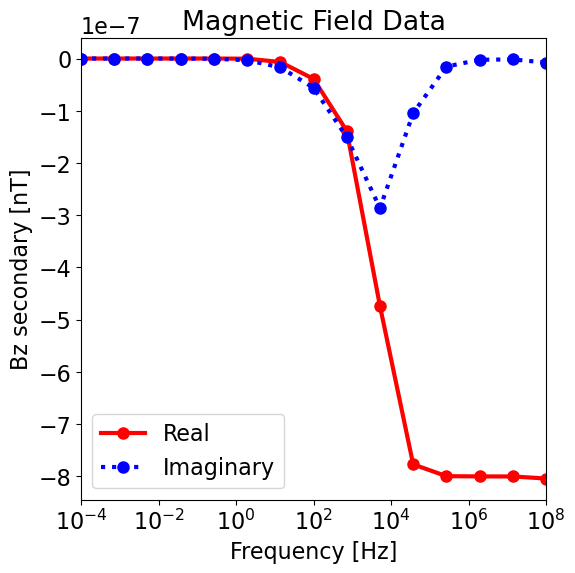

In [89]:
data = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((data.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = data[:, 0]
dobs_real = data[:, 1:ntx+1].T
dobs_imag = data[:, ntx+1:].T
dobs_real_flat = dobs_real.flatten()
dobs_imag_flat = dobs_imag.flatten()
dobs = np.empty(dobs_real_flat.size + dobs_imag_flat.size, dtype=dobs_real_flat.dtype)
dobs[0::2] = dobs_real_flat
dobs[1::2] = dobs_imag_flat


# Plot FEM response for all frequencies
location_index = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*dobs_real[location_index, :], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*dobs_imag[location_index, :], "b:o", lw=3)
ax.set_xlim((np.min(frequencies), np.max(frequencies)))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Bz secondary [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

## Survey

In [102]:
mesh = discretize.utils.load_mesh(file_name="./mesh/3d_mesh.json")
inversion_mesh_2d = discretize.utils.load_mesh(file_name="./mesh/inversion_mesh_2d.json")

# re-create the mapping:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface

resistivity_air = 1e8 #Assume known

mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, resistivity_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh_2d.nC
    )
)

In [ ]:
frequencies = np.logspace(-4, 8, 15)
sep = 10

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + sep, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(ntx): 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 100
            )
        )
        
# create the survey and problem objects for running the forward simulation
survey = fdem.survey.Survey(source_list)
prob = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, rhoMap=mapping, solver=Solver
)

## Define Uncertainty

In [ ]:
uncertainties = 0.01 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

## Weighted Least-Squares Inversion

In [ ]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

## Define Inverse Problem

In [ ]:
dmisfit = data_misfit.L2DataMisfit(simulation=prob, data=data_object)
reg = regularization.WeightedLeastSquares(inversion_mesh_2d)
opt = optimization.InexactGaussNewton(maxIterCG=10, remember="xc")
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

betaest = directives.BetaEstimate_ByEig(beta0_ratio=0.05, n_pw_iter=1, seed=1)
target = directives.TargetMisfit()

directiveList = [betaest, target]
inv = inversion.BaseInversion(invProb, directiveList=directiveList)

In [ ]:
m0 = np.log(estimated_resistivity) * np.ones(inversion_mesh_2d.nC)
mrec = inv.run(m0)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# put both plots on the same colorbar
clim = np.r_[np.log(1000), np.log(100)]

# recovered model
cb = plt.colorbar(
    inversion_mesh_2d.plot_image(mrec, ax=ax[0], clim=clim)[0],
    ax=ax[0],
)
ax[0].set_title("recovered model")
cb.set_label(r"$\log(\sigma)$")


ax[1].set_title("true model")
cb.set_label(r"$\log(\sigma)$")

# uncomment to plot the true interface
# x = np.linspace(-10, 10, 50)
# [a.plot(x, interface(x), 'k') for a in ax]

# [a.set_xlim([-10, 10]) for a in ax]
# [a.set_ylim([-2, 0]) for a in ax]

plt.tight_layout()
plt.show()